# Visualizing Arctic Area Anomalies With CMIP6 Data
#### Requirements: 
- Python (Anaconda recommended)
- IDE / Text editor that can handle Jupyter Notebooks
- Packages:
    - zarr
    - numpy
    - pandas
    - fsspec
    - matplotlib
    - xarray
    - gcsfs
    - tqdm
    - ipywidgets
    - cartopy
    - iris
    - seaborn
- System:
    - Tested on Windows but should work on Linux, too

#### Other:
- Please note that the program takes some time to run depending on how much data there is. 
The longest function has a progress bar to help visualize progress
- This program isn't suitable for data with a vertical coordinate
- More information (and examples) can be found on https://pangeo.io/
    

In [8]:
import zarr
import numpy as np
import pandas as pd
import fsspec
import matplotlib.pyplot as plt
import xarray as xa
from datetime import datetime as dt
import warnings
from tqdm.notebook import tqdm
import cartopy.crs as ccrs
from cartopy.util import add_cyclic_point
import seaborn as sns
import matplotlib.path as mpath
import iris
import cartopy

In [9]:
#disable warnings
warnings.simplefilter("ignore")

In [10]:
#read a list of CMIP models
df = pd.read_csv('https://storage.googleapis.com/cmip6/cmip6-zarr-consolidated-stores.csv')

In [11]:
#variable (examples: low clouds = cllcalipso, mid clouds = clmcalipso, high clouds = clhcalipso, sea ice thickness = sithick, near-surface air temperature = tas
# evaporation = evspsbl)
var = "cllcalipso"
#time pediod 1 (Y,M,D)
db1 = dt(1985,1,1)
de1 = dt(2014,12,31)
#time pediod 2 (Y,M,D)
db2 = dt(2015,1,1)
de2 = dt(2100,12,31)
#experiments
ex1 = "historical"
ex2 = "ssp245"
#max number of datasets per experiment
md = 10

In [12]:
#find the unique sources while keeping the order
def unique(sequence):
    seen = set()
    return [x for x in sequence if not (x in seen or seen.add(x))]

In [13]:
#load datasets from chosen sources
def get_datasets(variable : str, sources : list, experiment : str) -> list:
    ds_list = []
    for i, source in enumerate(sources):
        #single model
        result = df.query(f"variable_id == '{variable}' & experiment_id == '{experiment}' & source_id == '{source}'")
        #open dataset
        ds = xa.open_zarr(fsspec.get_mapper(result.zstore.values[0]), consolidated=True, decode_times=False)
        if i == 0:
            try:
                #get name for plotting
                name = ds[variable].long_name
            except:
                #in case of a failure just use the variable name
                name = variable
        #some coordinates can be inconsistent and it's easiest to ignore them
        if "lat" in ds[variable].dims and len(ds[variable]["time"]) < 10000:
            ds_list.append(ds)
        #limit the number of datasets (performance reasons)
        if len(ds_list) >= md:
            break
    return ds_list, name  

In [14]:
#group Xarray datasets as Pandas DataFrames
def group(ds : xa.Dataset, variable : str) -> xa.Dataset:
    #grouping is more efficient with Pandas DataFrames
    df_h = ds[variable].to_dataframe()
    df_h = df_h.reset_index()
    #regroup by years and months
    dff = df_h.groupby([df_h.time.dt.year, df_h.time.dt.month, "lat", "lon"])[[variable]].mean()
    dff.index.names = ["Years", "Months", "lat", "lon"]
    ds = dff.to_xarray()
    return ds

In [15]:
def process_datasets(datasets : list, variable : str, db : dt, de : dt, ref) -> tuple:
    processed = []
    mean_list = []
    #reference to use in regridding
    if ref is None:
        ref = datasets[0][variable].to_iris()
    elif type(ref) == tuple:
        ref = ref[0]
    #progress bar
    with tqdm(total=len(datasets), colour="green") as pbar:
        pbar.set_description("Processing given datasets")
        for dataset in datasets:
            #reformat time
            try:
                #times that are expressed as "x since" need to be changed
                if " ".join(dataset["time"].units.split(" ")[0:2]) == 'hours since':
                    #start point 
                    start = dataset["time"].units.split(" ")[2]
                    #hours -> days   
                    dataset["time"] = dataset["time"]/24
                else:
                    #start point
                    start = dataset["time"].units.split(" ")[2]
                try:
                    #timestamp needs to be possible to be created
                    pd.Timestamp(start)
                except:
                    #for dates of format "x since 0001-01-01"
                    dataset["time"] = dataset["time"] - 1849*365
                    #timestamp can't be smaller than 1677-09-21 so we convert the date to start from 1850-01-01
                    start = dt(1850,1,1)
                #convert time 
                dataset["time"] = pd.to_datetime(dataset["time"], unit='D',
                origin=pd.Timestamp(start))
            except:
                #if time is already in xx-xx-xxxx format or similar
                pass
            #all date formats to datetime
            dataset["time"] = dataset["time"].astype("datetime64[ns]")
            #regid to ref
            #DataArray -> Cube
            dataset = dataset[variable].to_iris()
            #regrid
            dataset = dataset.regrid(ref, iris.analysis.Linear())
            #Cube -> DataArray
            dataset = xa.DataArray.from_iris(dataset)
            #DataArray -> Dataset
            dataset = dataset.to_dataset()
            #southernmost latitude
            min_lat = dataset.sel(lat=66.5, method="nearest").lat.values
            #spatial limits (Artic area -> 66.5-90 N)
            dataset = dataset.sel(lat=slice(min_lat,90))
            #temporal limits, mean: reference period from 1850 to 1900, dataset: data from wanted time period
            mean = dataset.sel(time=slice(dt(1850,1,1),dt(1900,1,31)))
            dataset = dataset.sel(time=slice(db,de))
            #group by months, years
            ds = group(dataset, variable)
            ds_mean = group(mean, variable)
            processed.append(ds)
            mean_list.append(ds_mean)
            #update progress bar
            pbar.update(1)
    #ref is returned so that it can be used again with other experiments -> same coordinates for everything
    return processed, mean_list, ref

In [16]:
#helper function, uses the above functions and concatenates models together
def execute(variable : str, experiment : str, db : dt, de : dt, ref=None) -> tuple:
    #initial results with duplicate sources
    init = df.query(f"variable_id == '{variable}' & experiment_id == '{experiment}'")
    #unique source list
    sources = unique(init.source_id)
    #list of datasets
    dset_list, name = get_datasets(variable, sources, experiment)
    #not all sources are necessarily used so the sources are updateted
    sources = [ds.source_id for ds in dset_list]
    #process the datasets
    pros, mean_list, ref = process_datasets(dset_list, variable, db, de, ref)
    #average : data from chosen period from all models
    #ref_period : reference period of 1850-1900 from all models
    average = xa.concat(pros, pd.Index(sources, name="source_id"), coords='minimal').mean('source_id')[variable]
    ref_period  = xa.concat(mean_list, pd.Index(sources, name="source_id"), coords='minimal').mean('source_id')[variable]
    return average, ref_period, ref, name

In [18]:
#experiment 1 (historical in this example)
ave1, ref1, ref, name = execute(var, ex1, db1, de1)

  0%|          | 0/10 [00:00<?, ?it/s]

In [19]:
#experiment 2 (ssp245 in this example)
ave2, ref2, ref, _ = execute(var, ex2, db2, de2, ref)

  0%|          | 0/2 [00:00<?, ?it/s]

In [20]:
ds_list = []
#mean of reference period
ref = ref1.mean("Months").mean("Years")
#mean of months -> one value per year 
#this can also be reversed if we're interested in months rather than years (requires some tweaking, especially with the plot)
ave1 = ave1.mean("Months")
ave2 = ave2.mean("Months")
#calculate the anomalies
for i in range(len(ave1.Years)):
    #anomaly for each year, historical
    a = ave1.isel(Years=i)-ref
    ds_list.append(a)
for i in range(len(ave2.Years)):
    #anomaly for each year, ssp245
    a = ave2.isel(Years=i)-ref
    ds_list.append(a)

Text(0.5, 0.98, 'CALIPSO Percentage Low Level Cloud 1985-2100 (ref. period 1850-1900)')

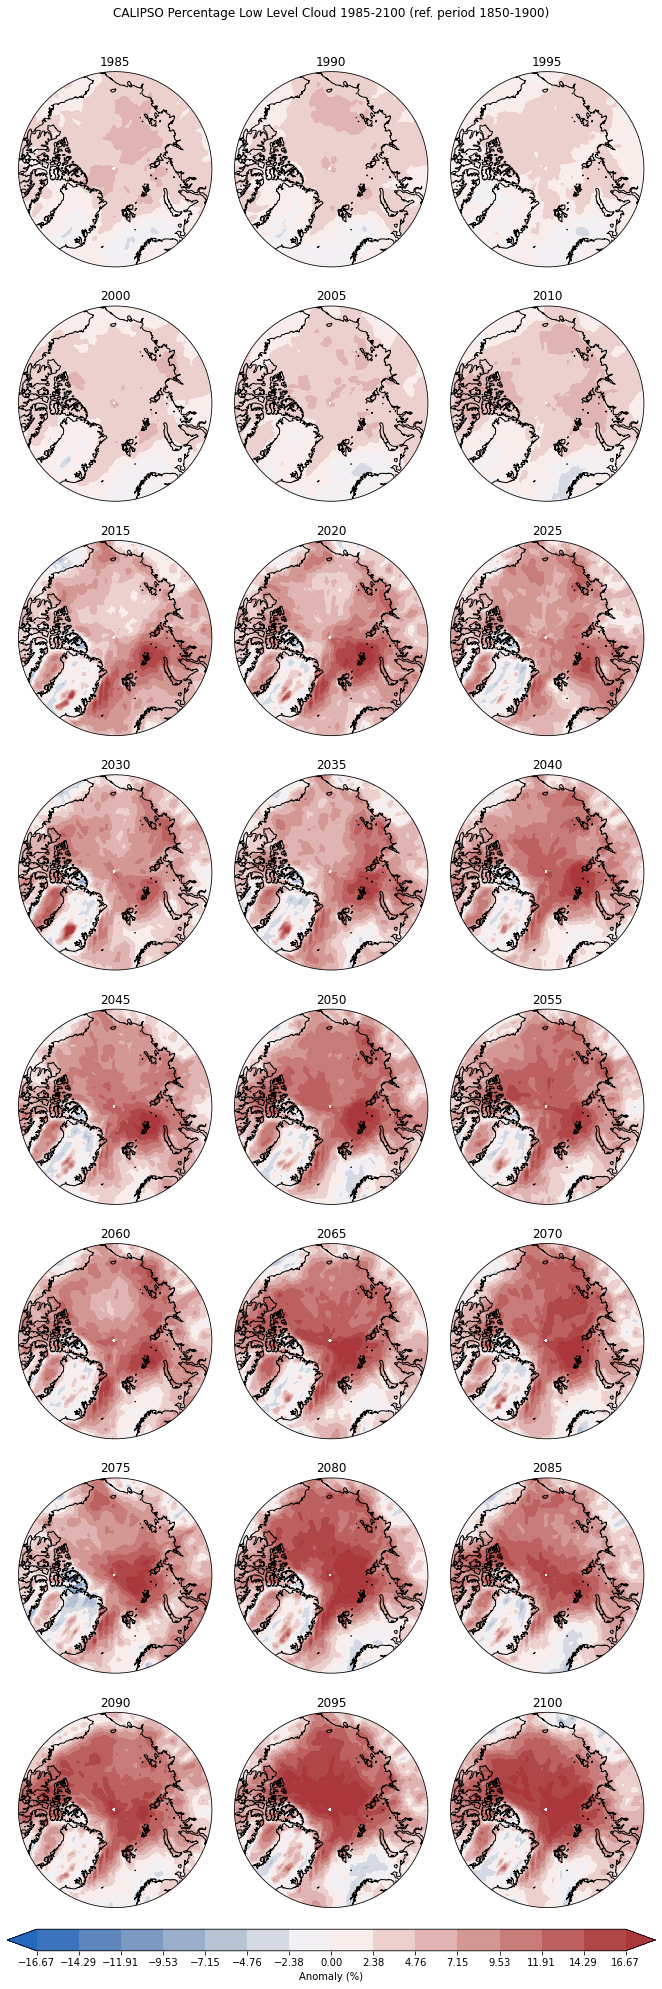

In [21]:
#define the contour levels to use in plt.contourf
#this is a baseline for the levels but one can do this manually as well if the result doesn't look too good
#mean of anomaly of last year times 1.7
max_v = abs(float((ave2.isel(Years=-1)-ref).mean()*1.7))
#15 levels from -max_v to max_v
clevs=np.linspace(-max_v,max_v,15)

#titles, 5 year interval
years = (list(ave1.Years.values)+list(ave2.Years.values))[::5]

#figure, subplots, projection
fig, axs = plt.subplots(nrows=8,ncols=3,
                        subplot_kw={'projection': ccrs.NorthPolarStereo()},
                        figsize=(30,30))

#flatten axes to 1D
axs=axs.flatten()
#looping over years
for i, model in enumerate(ds_list[::5]):

        #data for the year
        data=model
        #colormap
        cmap = sns.color_palette("vlag", as_cmap=True)
        #connecting the sides together
        data, lons = add_cyclic_point(data, coord=a["lon"])
        lats = a['lat']
        #filled contourmap (extend -> values that don't fit in levels go to tips of the colorbar insted of being white)
        cs = axs[i].contourf(lons, lats, data, clevs, transform=ccrs.PlateCarree(),cmap=cmap, extend="both")
        #limit the area of the plots
        axs[i].set_extent((0,361,66.5,90),crs=ccrs.PlateCarree())
        #turn maps into circles
        theta = np.linspace(0, 2*np.pi, 100)
        center, radius = [0.5,0.5], 0.5
        verts = np.vstack([np.sin(theta), np.cos(theta)]).T
        circle = mpath.Path(verts * radius + center)
        axs[i].set_boundary(circle, transform=axs[i].transAxes)

        #title for each subplot
        axs[i].set_title(years[i])

        #coastlines
        axs[i].coastlines()

        #fill land (e.g. sithick sometimes interprets terrestial snow as sea ice)
        #axs[i].add_feature(cartopy.feature.LAND, facecolor='gray', zorder=1)

#adjust sublot sizes and location
fig.subplots_adjust(bottom=0.1, top=0.95, left=0.35, right=0.65, wspace=0, hspace=0.2)
#axis for colorbar
cbar_ax = fig.add_axes([0.35, 0.08, 0.3, 0.01])
#colorbar, ticks from clev
cbar=fig.colorbar(cs, cax=cbar_ax,orientation='horizontal', ticks=clevs)
#colorbar title
cbar_ax.set_xlabel("Anomaly (%)")
#title for the whole plot
plt.suptitle(f'{name} {db1.year}-{de2.year} (ref. period 1850-1900)')